In [8]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D


In [9]:
from tensorflow.keras.optimizers import Adam # - Works
import random
from glob import glob
import seaborn as sns
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import matplotlib.pyplot as plt
import matplotlib.image as img
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

DATA Preprocessing

In [10]:
data_dir_train=pathlib.Path("E:\Code_playground\Skin Cancer\ISIC Model\Skin cancer ISIC The International Skin Imaging Collaboration\Train")
data_dir_test = pathlib.Path("E:\Code_playground\Skin Cancer\ISIC Model\Skin cancer ISIC The International Skin Imaging Collaboration\Test")

In [11]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [12]:
batch_size = 32
img_height = 180
img_width = 180
rnd_seed = 123
random.seed(rnd_seed)

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  validation_split=0.9,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Found 2239 files belonging to 9 classes.
Using 447 files for validation.
Found 118 files belonging to 9 classes.
Using 106 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


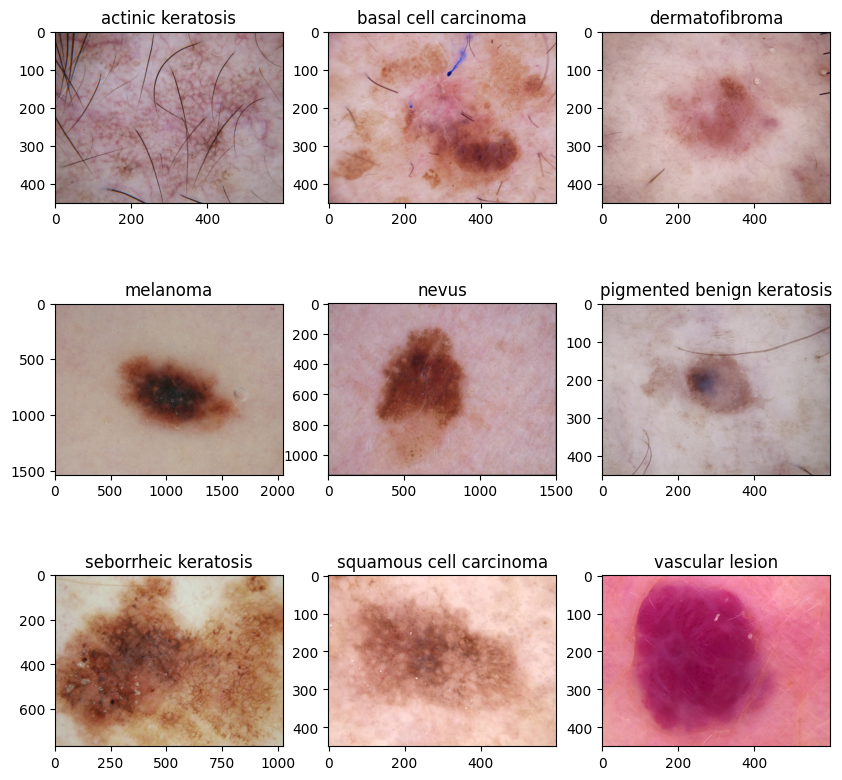

In [10]:
num_classes = len(class_names)
plt.figure(figsize=(10,10))
for i in range(num_classes):
  plt.subplot(3,3,i+1)
  image = img.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

In [8]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

(32, 180, 180, 3)
(32,)


In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Creating CNN Layers

In [10]:
num_classes = 9
model = Sequential([layers.experimental.preprocessing.Rescaling \
                    (1.0/255,input_shape=(img_height,img_width,3))])

model.add(Conv2D(32, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(64, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(128, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(256, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(512, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Flatten())
model.add(Dense(1024,activation="relu"))
model.add(Dense(units=num_classes, activation= 'softmax'))

In [11]:
opt = Adam(lr=0.001)
model.compile(optimizer= opt,loss= SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 128)       7

In [13]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=25
)

Epoch 1/25
56/56 [==============================] - 199s 3s/step - loss: 2.0647 - accuracy: 0.2176 - val_loss: 2.0100 - val_accuracy: 0.2349
Epoch 2/25
10/56 [====>.........................] - ETA: 2:14 - loss: 1.9520 - accuracy: 0.2188

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Model 2 : Data Augumentation with drop out layer.

In [15]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", input_shape=(img_height,img_width,3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
  ]
)

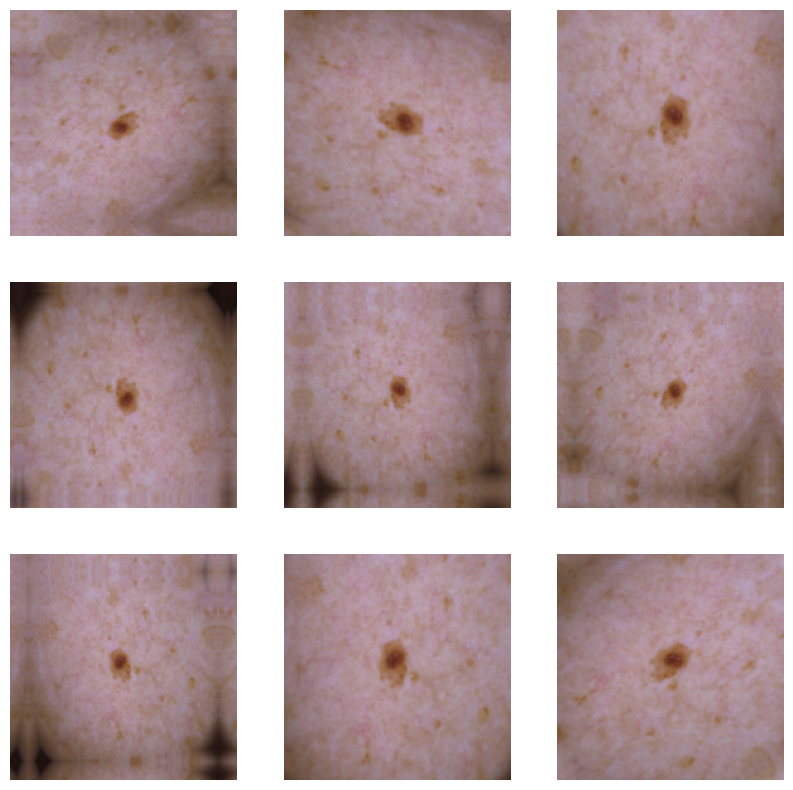

In [16]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [17]:
num_classes = 9
model = Sequential(data_augmentation)
model.add(layers.experimental.preprocessing.Rescaling(1.0/255,input_shape=(img_height,img_width,3)))

model.add(Conv2D(32, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(64, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(128, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.15))

model.add(Conv2D(256, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.20))

model.add(Conv2D(512, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024,activation="relu"))
model.add(Dense(units=num_classes, activation= 'softmax'))

In [18]:
opt = Adam(lr=0.001)
model.compile(optimizer=opt,loss= SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [ ]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=25
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, optimizers

Augmentor : Class balance

In [24]:
import os
output_directory = os.getcwd() + '/augmented_images/'

In [25]:
# List all directories (classes) in the data directory
class_names = os.listdir(data_dir_train)

# Iterate through each class and count the number of images
for class_name in class_names:
    class_path = os.path.join(data_dir_train, class_name)
    if os.path.isdir(class_path):  # Check if it's a directory
        num_images = len(os.listdir(class_path))
        print(f'Class: {class_name}, Number of Images: {num_images}')

Class: actinic keratosis, Number of Images: 114
Class: basal cell carcinoma, Number of Images: 376
Class: dermatofibroma, Number of Images: 95
Class: melanoma, Number of Images: 438
Class: nevus, Number of Images: 357
Class: pigmented benign keratosis, Number of Images: 462
Class: seborrheic keratosis, Number of Images: 77
Class: squamous cell carcinoma, Number of Images: 181
Class: vascular lesion, Number of Images: 139


In [26]:
import Augmentor
import os
import pathlib

# Define the path to the training dataset
path_to_training_dataset = pathlib.Path(r'E:\Code_playground\Skin Cancer\ISIC Model\Skin cancer ISIC The International Skin Imaging Collaboration\Train')
output_directory = os.getcwd() + '/data/'

# Convert class_names to a list if it's not already
class_names = list(class_names)

# Iterate through each class and create Augmentor pipeline
for i in class_names:
    p = Augmentor.Pipeline(str(path_to_training_dataset / i), output_directory=str(output_directory + i + '/output/'))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Initialised with 114 image(s) found.
Output directory set to e:\Code_playground\Skin Cancer\ISIC Model\Skin cancer ISIC The International Skin Imaging Collaboration/data/actinic keratosis/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x24B2A87B9D0>: 100%|██████████| 500/500 [00:07<00:00, 68.34 Samples/s]


Initialised with 376 image(s) found.
Output directory set to e:\Code_playground\Skin Cancer\ISIC Model\Skin cancer ISIC The International Skin Imaging Collaboration/data/basal cell carcinoma/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x24B2974E650>: 100%|██████████| 500/500 [00:08<00:00, 61.16 Samples/s]


Initialised with 95 image(s) found.
Output directory set to e:\Code_playground\Skin Cancer\ISIC Model\Skin cancer ISIC The International Skin Imaging Collaboration/data/dermatofibroma/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x24B29827940>: 100%|██████████| 500/500 [00:07<00:00, 66.52 Samples/s]


Initialised with 438 image(s) found.
Output directory set to e:\Code_playground\Skin Cancer\ISIC Model\Skin cancer ISIC The International Skin Imaging Collaboration/data/melanoma/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=722x542 at 0x24B2B654490>: 100%|██████████| 500/500 [00:34<00:00, 14.29 Samples/s]  


Initialised with 357 image(s) found.
Output directory set to e:\Code_playground\Skin Cancer\ISIC Model\Skin cancer ISIC The International Skin Imaging Collaboration/data/nevus/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x24B29890E50>: 100%|██████████| 500/500 [00:35<00:00, 14.06 Samples/s]  


Initialised with 462 image(s) found.
Output directory set to e:\Code_playground\Skin Cancer\ISIC Model\Skin cancer ISIC The International Skin Imaging Collaboration/data/pigmented benign keratosis/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x24B2B58D720>: 100%|██████████| 500/500 [00:08<00:00, 57.78 Samples/s]


Initialised with 77 image(s) found.
Output directory set to e:\Code_playground\Skin Cancer\ISIC Model\Skin cancer ISIC The International Skin Imaging Collaboration/data/seborrheic keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x24B2A7859C0>: 100%|██████████| 500/500 [00:15<00:00, 31.62 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to e:\Code_playground\Skin Cancer\ISIC Model\Skin cancer ISIC The International Skin Imaging Collaboration/data/squamous cell carcinoma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x24B27C104F0>: 100%|██████████| 500/500 [00:07<00:00, 67.28 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to e:\Code_playground\Skin Cancer\ISIC Model\Skin cancer ISIC The International Skin Imaging Collaboration/data/vascular lesion/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x24B318EFCA0>: 100%|██████████| 500/500 [00:08<00:00, 61.95 Samples/s]                  


In [27]:
output_dir = pathlib.Path(output_directory)  # Convert output directory to a Path object
image_count_train = len(list(output_dir.glob('*/output/*.jpg')))
print(image_count_train)

4500


total training image count = 4500 

-------------------------------------
Class name =  actinic keratosis
count      =  500
proportion =  0.1111111111111111
-------------------------------------
Class name =  basal cell carcinoma
count      =  500
proportion =  0.1111111111111111
-------------------------------------
Class name =  dermatofibroma
count      =  500
proportion =  0.1111111111111111
-------------------------------------
Class name =  melanoma
count      =  500
proportion =  0.1111111111111111
-------------------------------------
Class name =  nevus
count      =  500
proportion =  0.1111111111111111
-------------------------------------
Class name =  pigmented benign keratosis
count      =  500
proportion =  0.1111111111111111
-------------------------------------
Class name =  seborrheic keratosis
count      =  500
proportion =  0.1111111111111111
-------------------------------------
Class name =  squamous cell carcinoma
count      =  500
proportion =  0.1111111111111111

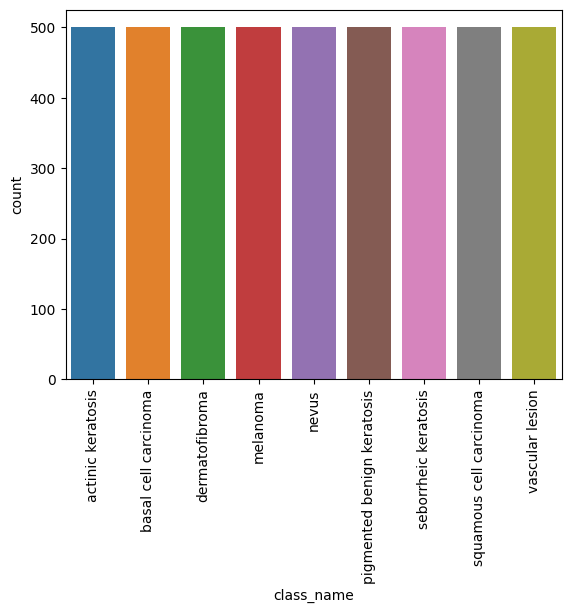

In [28]:
num_classes = len(class_names)
total = 0
all_count = []
class_name = []

for i in range(num_classes):
  count = len(list(output_dir.glob(class_names[i]+'/output/*.jpg')))
  total += count
print("total training image count = {} \n".format(total))
print("-------------------------------------")
for i in range(num_classes):
  count = len(list(output_dir.glob(class_names[i]+'/output/*.jpg')))
  print("Class name = ",class_names[i])
  print("count      = ",count)
  print("proportion = ",count/total)
  print("-------------------------------------")
  all_count.append(count)
  class_name.append(class_names[i])
temp_df = pd.DataFrame(list(zip(all_count, class_name)), columns = ['count', 'class_name'])
sns.barplot(data=temp_df, y="count", x="class_name")
plt.xticks(rotation=90)
plt.show()

Model 3 : Model with Class balance data.

In [29]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 3600 files for training.


In [30]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 900 files for validation.


In [31]:
print(train_ds.class_names)


['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [32]:
num_classes = 9
model = Sequential([layers.experimental.preprocessing.Rescaling(1.0/255,input_shape=(img_height,img_width,3))])

model.add(Conv2D(32, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(64, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(128, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.15))

model.add(Conv2D(256, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.20))

model.add(Conv2D(512, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024,activation="relu"))
model.add(Dense(units=num_classes, activation= 'softmax'))

In [33]:
opt = Adam(lr=0.001)
model.compile(optimizer= opt,loss = SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [ ]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=25
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


Model : Transefer learning Model

RESNET50


In [34]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, optimizers

In [35]:
resnet_model = Sequential()

pretrained_model= keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(180,180,3),
    pooling='max',
    classes=9,
    classifier_activation="softmax",
)

for layer in pretrained_model.layers:
    layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(1024, activation='relu'))
resnet_model.add(Dense(9, activation='softmax'))

94765736/94765736 [==============================] - 201s 2us/step


In [36]:
# Compile the model
opt = optimizers.Adam(lr=0.001)
resnet_model.compile(optimizer=opt,loss='sparse_categorical_crossentropy',  # Use sparse categorical crossentropy for integer labels
              metrics=['accuracy'])

In [37]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)

Epoch 1/20
113/113 [==============================] - 222s 2s/step - loss: 2.2134 - accuracy: 0.1167 - val_loss: 2.1997 - val_accuracy: 0.1011
Epoch 2/20
 11/113 [=>............................] - ETA: 2:42 - loss: 2.1989 - accuracy: 0.1080

KeyboardInterrupt: 

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Load and preprocess the image
image_path = r'C:\Users\Sakshi\OneDrive\Desktop\Skin Data\Skin cancer ISIC The International Skin Imaging Collaboration\Train\melanoma\ISIC_0000299.jpg'  # Replace with the path to your image
img = load_img(image_path, target_size=(180, 180))  # Adjust target_size based on your model's input shape
img = img_to_array(img)
img = np.expand_dims(img, axis=0)

# Make a prediction using the skin cancer classification model
prediction = resnet_model.predict(img)

# Debugging information
print("Shape of prediction array:", prediction.shape)
print("Prediction array:", prediction)

# Determine the class label based on the prediction
class_labels = ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']

# Check if the prediction shape matches the number of classes
if prediction.shape[-1] == len(class_labels):
    class_label = class_labels[np.argmax(prediction)]
    print(f"Predicted class: {class_label}")
else:
    print("Number of classes in prediction does not match the number of class labels.")

In [ ]:
import matplotlib.pyplot as plt

# Load the actual image
actual_img = load_img(image_path, target_size=(180, 180))  # Load the original image

# Plot the actual image
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.imshow(actual_img)
plt.title(f"Actual Image: {class_label}")
plt.axis('off')

# Plot the predicted image
plt.subplot(1, 2, 2)
plt.imshow(img[0].astype('uint8'))  # Convert to uint8 for imshow
plt.title(f"Predicted: {class_label}")
plt.axis('off')

# Show the plot
plt.show()

#### Inception V3

In [1]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers

In [2]:
base_model = InceptionV3(weights='imagenet', include_top=False)

# Add a global average pooling layer and a dense layer for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(9, activation='softmax')(x)

In [3]:
model = Model(inputs=base_model.input, outputs=predictions)

In [4]:
# Compile the model
opt = optimizers.Adam(lr=0.001)
base_model.compile(optimizer=opt,loss='sparse_categorical_crossentropy',  # Use sparse categorical crossentropy for integer labels
              metrics=['accuracy'])

c:\Users\abhis\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [5]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [6]:
validation_datagen = ImageDataGenerator(rescale=1.0 / 255)

In [13]:
train_generator = train_datagen.flow_from_directory(
    data_dir_train,
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

Found 2239 images belonging to 9 classes.


In [14]:
test_generator = validation_datagen.flow_from_directory(
    data_dir_test,
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 118 images belonging to 9 classes.


In [16]:
model.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

In [17]:
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    epochs=10
)

Epoch 1/10
 1/69 [..............................] - ETA: 34:17 - loss: 0.7748 - accuracy: 0.2188

KeyboardInterrupt: 

In [18]:
from tensorflow.keras.callbacks import LambdaCallback

print_callback = LambdaCallback(
    on_epoch_end=lambda epoch, logs: print(
        f"Epoch: {epoch+1}, Loss: {logs['loss']:.4f}, Accuracy: {logs['accuracy']:.4f}, Val Loss: {logs['val_loss']:.4f}, Val Accuracy: {logs['val_accuracy']:.4f}, LR: {model.optimizer.lr.numpy():.4f}"
    )
)

In [19]:
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    epochs=10,
    callbacks=[print_callback]
)

Epoch 1/10
 2/69 [..............................] - ETA: 15:31 - loss: 0.4003 - accuracy: 0.2188

KeyboardInterrupt: 

#### Hybrid Model (Inceptio V3 + DenseNet)

In [20]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3, DenseNet121
from tensorflow.keras.layers import Concatenate, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

In [22]:
img_height, img_width = 224, 224
batch_size = 32
epochs = 50

In [23]:
# Inception V3
base_model_inception = tf.keras.applications.InceptionV3(
    include_top=False,
    input_shape=(img_height, img_width, 3),
    weights='imagenet'
)

# DenseNet
base_model_densenet = tf.keras.applications.DenseNet121(
    include_top=False,
    input_shape=(img_height, img_width, 3),
    weights='imagenet'
)

In [25]:
# Load the pre-trained models
inception_model = InceptionV3(include_top=False, input_shape=(224, 224, 3))
densenet_model = DenseNet121(include_top=False, input_shape=(224, 224, 3))

# Remove the top layers
inception_model.layers.pop()
densenet_model.layers.pop()

In [28]:
from tensorflow.keras.applications import DenseNet121

# Load the DenseNet model
densenet_model = DenseNet121(include_top=False, weights='imagenet')

# Extract features from the DenseNet model
densenet_model_features = densenet_model.output

In [30]:
from tensorflow.keras.applications import InceptionV3

# Load the Inception V3 model
model_365 = InceptionV3(include_top=False, weights='imagenet')

# Extract features from the Inception V3 model
model_365_features = model_365.output

In [31]:
from tensorflow.keras.layers import Conv2D

# ...

# Add a convolutional layer with 1x1 filters to the DenseNet model to reduce its depth
densenet_model_features = Conv2D(2048, (1, 1), activation='relu')(densenet_model_features)

# Concatenate the feature maps
merged_features = Concatenate()([model_365_features, densenet_model_features])

In [41]:
# Compile the model
opt = tf.keras.optimizers.Adam(lr=0.0001)
model.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

In [35]:
# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    data_dir_train,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    data_dir_test,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 2239 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


In [40]:
# Callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

callbacks = [reduce_lr, early_stopping, checkpoint]

In [48]:
history = model.fit(
    train_generator, 
    validation_data=validation_generator, 
    epochs=10,
    validation_split=0.1,
    callbacks = callbacks
)

Epoch 1/10
10/70 [===>..........................] - ETA: 6:58 - loss: 2.0034 - accuracy: 0.3000

KeyboardInterrupt: 